<a href="https://colab.research.google.com/github/youssef-snoussi/Deep-Learning-Pro/blob/master/Brain_Cancer_Classification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Data Preparation
## Downloading the data from Kaggle

In [2]:
from google.colab import files
files.upload()

Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"yulolollo","key":"e95f961c5bb8087116aa61cf1126ad7e"}'}

In [3]:
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json
!kaggle datasets download -d mateuszbuda/lgg-mri-segmentation

 98% 699M/714M [00:06<00:00, 91.6MB/s]
100% 714M/714M [00:06<00:00, 110MB/s] 


In [4]:
!unzip -q "/content/lgg-mri-segmentation.zip"

In [5]:
import pandas as pd

path = '/content/kaggle_3m/'
data = pd.read_csv(path + f"/data.csv")
data.head()

,Patient,RNASeqCluster,MethylationCluster,miRNACluster,CNCluster,RPPACluster,OncosignCluster,COCCluster,histological_type,neoplasm_histologic_grade,tumor_tissue_site,laterality,tumor_location,gender,age_at_initial_pathologic,race,ethnicity,death01
0,TCGA_CS_4941,2.0,4.0,2,2.0,NaN,3.0,2,1.0,2.0,1.0,3.0,2.0,2.0,67.0,3.0,2.0,1.0
1,TCGA_CS_4942,1.0,5.0,2,1.0,1.0,2.0,1,1.0,2.0,1.0,3.0,2.0,1.0,44.0,2.0,NaN,1.0
2,TCGA_CS_4943,1.0,5.0,2,1.0,2.0,2.0,1,1.0,2.0,1.0,1.0,2.0,2.0,37.0,3.0,NaN,0.0
3,TCGA_CS_4944,NaN,5.0,2,1.0,2.0,1.0,1,1.0,1.0,1.0,3.0,6.0,2.0,50.0,3.0,NaN,0.0
4,TCGA_CS_5393,4.0,5.0,2,1.0,2.0,3.0,1,1.0,2.0,1.0,1.0,6.0,2.0,39.0,3.0,NaN,0.0


## Getting images paths

In [6]:
import glob
import os

data_map = []
for dir in glob.glob(path+'*'):
    try:
        dir_name = dir.split('/')[-1]
        for file in os.listdir(dir):
            image_path = dir + '/' + file
            data_map.extend([dir_name, image_path])
    except Exception as e:
        print(e)

[Errno 20] Not a directory: '/content/kaggle_3m/README.md'
[Errno 20] Not a directory: '/content/kaggle_3m/data.csv'


In [7]:
df = pd.DataFrame({"patient_id" : data_map[::2],
                   "path" : data_map[1::2]})
df.head()

,patient_id,path
0,TCGA_DU_7008_19830723,/content/kaggle_3m/TCGA_DU_7008_19830723/TCGA_...
1,TCGA_DU_7008_19830723,/content/kaggle_3m/TCGA_DU_7008_19830723/TCGA_...
2,TCGA_DU_7008_19830723,/content/kaggle_3m/TCGA_DU_7008_19830723/TCGA_...
3,TCGA_DU_7008_19830723,/content/kaggle_3m/TCGA_DU_7008_19830723/TCGA_...
4,TCGA_DU_7008_19830723,/content/kaggle_3m/TCGA_DU_7008_19830723/TCGA_...


In [8]:
len(df['path'][1])

69

In [9]:
import random

df_imgs = df[~df['path'].str.contains("mask")]
df_masks = df[df['path'].str.contains("mask")]

BASE_LEN = 74
END_IMG_LEN = 4 
END_MASK_LEN = 9 

# Data sorting
imgs = sorted(df_imgs["path"].values, key=lambda x : x[:-END_IMG_LEN])
masks = sorted(df_masks["path"].values, key=lambda x : x[:-END_MASK_LEN])

# Sorting check
idx = random.randint(0, len(imgs)-1)
print("Path to the Image:", imgs[idx], "\nPath to the Mask:", masks[idx])

Path to the Image: /content/kaggle_3m/TCGA_DU_6401_19831001/TCGA_DU_6401_19831001_1.tif 
Path to the Mask: /content/kaggle_3m/TCGA_DU_6401_19831001/TCGA_DU_6401_19831001_1_mask.tif


## Final Dataset
Here we prepare a dataframe with images and their correspnding masks and their paths with an additional colmn indicating if it's infected or not 

In [10]:
import numpy as np
import cv2

# Final dataframe
brain_df = pd.DataFrame({"patient_id": df_imgs.patient_id.values,
                         "image_path": imgs,
                         "mask_path": masks
                        })
def pos_neg_diagnosis(mask_path):
    value = np.max(cv2.imread(mask_path))
    if value > 0 : 
        return 1
    else:
        return 0
    
brain_df['mask'] = brain_df['mask_path'].apply(lambda x: pos_neg_diagnosis(x))
brain_df

,patient_id,image_path,mask_path,mask
0,TCGA_DU_7008_19830723,/content/kaggle_3m/TCGA_CS_4941_19960909/TCGA_...,/content/kaggle_3m/TCGA_CS_4941_19960909/TCGA_...,0
1,TCGA_DU_7008_19830723,/content/kaggle_3m/TCGA_CS_4941_19960909/TCGA_...,/content/kaggle_3m/TCGA_CS_4941_19960909/TCGA_...,0
2,TCGA_DU_7008_19830723,/content/kaggle_3m/TCGA_CS_4941_19960909/TCGA_...,/content/kaggle_3m/TCGA_CS_4941_19960909/TCGA_...,1
3,TCGA_DU_7008_19830723,/content/kaggle_3m/TCGA_CS_4941_19960909/TCGA_...,/content/kaggle_3m/TCGA_CS_4941_19960909/TCGA_...,1
4,TCGA_DU_7008_19830723,/content/kaggle_3m/TCGA_CS_4941_19960909/TCGA_...,/content/kaggle_3m/TCGA_CS_4941_19960909/TCGA_...,1
...,...,...,...,...
3924,TCGA_CS_6665_20010817,/content/kaggle_3m/TCGA_HT_A61B_19991127/TCGA_...,/content/kaggle_3m/TCGA_HT_A61B_19991127/TCGA_...,0
3925,TCGA_CS_6665_20010817,/content/kaggle_3m/TCGA_HT_A61B_19991127/TCGA_...,/content/kaggle_3m/TCGA_HT_A61B_19991127/TCGA_...,0
3926,TCGA_CS_6665_20010817,/content/kaggle_3m/TCGA_HT_A61B_19991127/TCGA_...,/content/kaggle_3m/TCGA_HT_A61B_19991127/TCGA_...,0
3927,TCGA_CS_6665_20010817,/content/kaggle_3m/TCGA_HT_A61B_19991127/TCGA_...,/content/kaggle_3m/TCGA_HT_A61B_19991127/TCGA_...,0


# Data visualisation

In [11]:
brain_df['mask'].value_counts()

0    2556
1    1373
Name: mask, dtype: int64

Text(0.5, 1.0, 'Tumor Location')

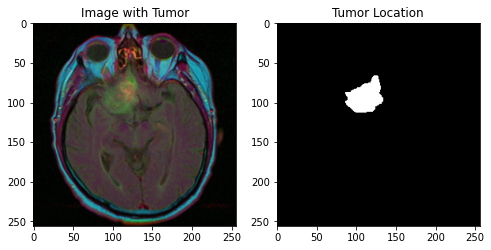

In [12]:
import matplotlib.pyplot as plt

for i in range(len(brain_df)):
    if cv2.imread(brain_df.mask_path[i]).max() > 0:
        break

plt.figure(figsize=(8,8))
plt.subplot(1,2,1)
plt.imshow(cv2.imread(brain_df.image_path[i]))
plt.title('Image with Tumor')

plt.subplot(1,2,2)
plt.imshow(cv2.imread(brain_df.mask_path[i]))
plt.title('Tumor Location')

# Spliting the Data into Train Test and Validation sets

In [13]:
brain_df_train = brain_df.drop(columns=['patient_id'])
# Convert the data in mask column to string format, to use categorical mode in flow_from_dataframe
brain_df_train['mask'] = brain_df_train['mask'].apply(lambda x: str(x))
brain_df_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3929 entries, 0 to 3928
Data columns (total 3 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   image_path  3929 non-null   object
 1   mask_path   3929 non-null   object
 2   mask        3929 non-null   object
dtypes: object(3)
memory usage: 92.2+ KB


In [14]:
from sklearn.model_selection import train_test_split

train, test = train_test_split(brain_df_train, test_size=0.15)

In [15]:
from keras_preprocessing.image import ImageDataGenerator

datagen = ImageDataGenerator(rescale=1./255., validation_split=0.1)

train_generator = datagen.flow_from_dataframe(train,
                                              directory='./',
                                              x_col='image_path',
                                              y_col='mask',
                                              subset='training',
                                              class_mode='categorical',
                                              batch_size=16,
                                              shuffle=True,
                                              target_size=(256,256)
                                             )
valid_generator = datagen.flow_from_dataframe(train,
                                              directory='./',
                                              x_col='image_path',
                                              y_col='mask',
                                              subset='validation',
                                              class_mode='categorical',
                                              batch_size=16,
                                              shuffle=True,
                                              target_size=(256,256)
                                             )
test_datagen = ImageDataGenerator(rescale=1./255.)
test_generator = test_datagen.flow_from_dataframe(test,
                                                  directory='./',
                                                  x_col='image_path',
                                                  y_col='mask',
                                                  class_mode='categorical',
                                                  batch_size=16,
                                                  shuffle=False,
                                                  target_size=(256,256)
                                                 )

Found 3006 validated image filenames belonging to 2 classes.
Found 333 validated image filenames belonging to 2 classes.
Found 590 validated image filenames belonging to 2 classes.


# Pretrained models Benchmark 

### VGG16

In [16]:
from keras.applications.vgg16 import preprocess_input, VGG16
# load model without output layer
VGG16_base = VGG16(input_shape = [256, 256, 3], weights = "imagenet", include_top=False)

VGG16_base.trainable = False

58892288/58889256 [==============================] - 0s 0us/step


In [17]:
from keras.layers import Dense, Flatten

x = Flatten()(VGG16_base.output)
pre = Dense(2, activation = "sigmoid")(x)

In [18]:
from keras.models import Model
model_vgg16 = Model(inputs = VGG16_base.input, outputs = pre)

In [19]:
model_vgg16.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 256, 256, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 256, 256, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 256, 256, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 128, 128, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 128, 128, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 128, 128, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 64, 64, 128)       0     

In [20]:
model_vgg16.compile(loss = 'binary_crossentropy', optimizer="adam", metrics=["accuracy"])
history_vgg16 = model_vgg16.fit_generator(train_generator, validation_data=valid_generator, epochs = 15)

/usr/local/lib/python3.6/dist-packages/tensorflow/python/keras/engine/training.py:1844: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


Epoch 1/15
188/188 [==============================] - 17s 54ms/step - loss: 0.5941 - accuracy: 0.7500 - val_loss: 0.3227 - val_accuracy: 0.8619
Epoch 2/15
188/188 [==============================] - 9s 47ms/step - loss: 0.3267 - accuracy: 0.8598 - val_loss: 0.2811 - val_accuracy: 0.8889
Epoch 3/15
188/188 [==============================] - 9s 46ms/step - loss: 0.2360 - accuracy: 0.9036 - val_loss: 0.2463 - val_accuracy: 0.9009
Epoch 4/15
188/188 [==============================] - 9s 47ms/step - loss: 0.2040 - accuracy: 0.9250 - val_loss: 0.2642 - val_accuracy: 0.8919
Epoch 5/15
188/188 [==============================] - 9s 47ms/step - loss: 0.1445 - accuracy: 0.9487 - val_loss: 0.2358 - val_accuracy: 0.9039
Epoch 6/15
188/188 [==============================] - 9s 47ms/step - loss: 0.1368 - accuracy: 0.9497 - val_loss: 0.2494 - val_accuracy: 0.8889
Epoch 7/15
188/188 [==============================] - 9s 47ms/step - loss: 0.1244 - accuracy: 0.9550 - val_loss: 0.2364 - val_accuracy: 0.918

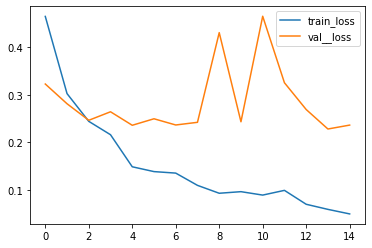

In [21]:
plt.plot(history_vgg16.history["loss"], label = "train_loss")
plt.plot(history_vgg16.history["val_loss"], label = "val__loss")
plt.legend()
plt.show()

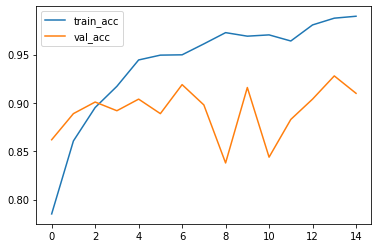

In [22]:
plt.plot(history_vgg16.history["accuracy"], label = "train_acc")
plt.plot(history_vgg16.history["val_accuracy"], label = "val_acc")
plt.legend()
plt.show()

In [23]:
_, acc = model_vgg16.evaluate(test_generator)
print("Test accuracy : {} %".format(acc*100))

37/37 [==============================] - 2s 42ms/step - loss: 0.1531 - accuracy: 0.9305
Test accuracy : 93.05084943771362 %


0.9305084745762712
              precision    recall  f1-score   support

           0       0.94      0.95      0.95       376
           1       0.92      0.89      0.90       214

    accuracy                           0.93       590
   macro avg       0.93      0.92      0.92       590
weighted avg       0.93      0.93      0.93       590



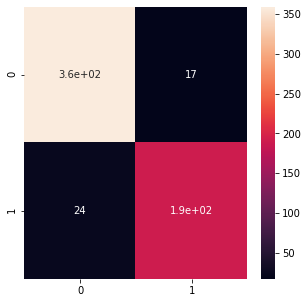

In [25]:
import seaborn as sns

prediction = model_vgg16.predict(test_generator)

pred = np.argmax(prediction, axis=1)
#pred = np.asarray(pred).astype('str')
original = np.asarray(test['mask']).astype('int')

from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
accuracy = accuracy_score(original, pred)
print(accuracy)

cm = confusion_matrix(original, pred)

report = classification_report(original, pred, labels = [0,1])
print(report)
plt.figure(figsize = (5,5))
sns.heatmap(cm, annot=True);

In [26]:
from tensorflow import keras
# Fine tuning 
# Unfreeze the base model
VGG16_base.trainable = True

model_vgg16.compile(loss = 'binary_crossentropy', optimizer=keras.optimizers.Adam(1e-5), metrics=["accuracy"])

# Train end-to-end. Be careful to stop before you overfit!
result_model = model_vgg16.fit(train_generator, validation_data=valid_generator, epochs = 7)

Epoch 1/7
188/188 [==============================] - 29s 144ms/step - loss: 0.1037 - accuracy: 0.9639 - val_loss: 0.2760 - val_accuracy: 0.9009
Epoch 2/7
188/188 [==============================] - 26s 140ms/step - loss: 0.0583 - accuracy: 0.9787 - val_loss: 0.2846 - val_accuracy: 0.9249
Epoch 3/7
188/188 [==============================] - 26s 140ms/step - loss: 0.0448 - accuracy: 0.9860 - val_loss: 0.2465 - val_accuracy: 0.9279
Epoch 4/7
188/188 [==============================] - 26s 140ms/step - loss: 0.0293 - accuracy: 0.9903 - val_loss: 0.3003 - val_accuracy: 0.9339
Epoch 5/7
188/188 [==============================] - 26s 140ms/step - loss: 0.0172 - accuracy: 0.9943 - val_loss: 0.2694 - val_accuracy: 0.9369
Epoch 6/7
188/188 [==============================] - 26s 140ms/step - loss: 0.0135 - accuracy: 0.9979 - val_loss: 0.2831 - val_accuracy: 0.9369
Epoch 7/7
188/188 [==============================] - 26s 140ms/step - loss: 0.0188 - accuracy: 0.9935 - val_loss: 0.2942 - val_accuracy:

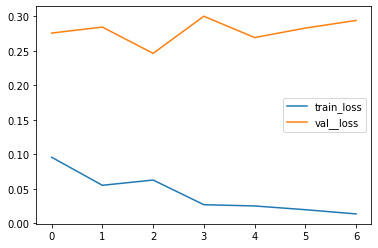

In [27]:
plt.plot(result_model.history["loss"], label = "train_loss")
plt.plot(result_model.history["val_loss"], label = "val__loss")
plt.legend()
plt.show()

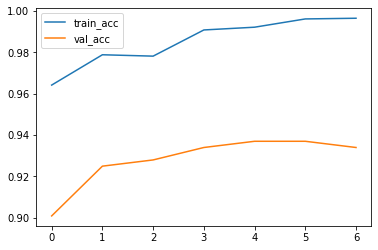

In [28]:
plt.plot(result_model.history["accuracy"], label = "train_acc")
plt.plot(result_model.history["val_accuracy"], label = "val_acc")
plt.legend()
plt.show()

In [29]:
_, acc = model_vgg16.evaluate(test_generator)
print("Test accuracy : {} %".format(acc*100))

37/37 [==============================] - 2s 42ms/step - loss: 0.1455 - accuracy: 0.9441
Test accuracy : 94.40677762031555 %


0.9440677966101695
              precision    recall  f1-score   support

           0       0.98      0.94      0.96       376
           1       0.90      0.96      0.93       214

    accuracy                           0.94       590
   macro avg       0.94      0.95      0.94       590
weighted avg       0.95      0.94      0.94       590



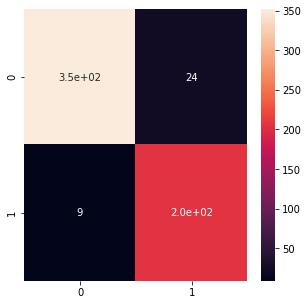

In [30]:
prediction = model_vgg16.predict(test_generator)

pred = np.argmax(prediction, axis=1)
#pred = np.asarray(pred).astype('str')
original = np.asarray(test['mask']).astype('int')

from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
accuracy = accuracy_score(original, pred)
print(accuracy)

cm = confusion_matrix(original, pred)

report = classification_report(original, pred, labels = [0,1])
print(report)
plt.figure(figsize = (5,5))
sns.heatmap(cm, annot=True);

## Inception V3

In [31]:
from keras.applications.inception_v3 import InceptionV3

inception_base = InceptionV3(input_shape = [256, 256, 3], weights = "imagenet", include_top=False)

inception_base.trainable = False

87916544/87910968 [==============================] - 1s 0us/step


In [32]:
x = Flatten()(inception_base.output)
pre = Dense(2, activation = "sigmoid")(x)

In [33]:
model_Inceptionv3 = Model(inputs = inception_base.input, outputs = pre)

In [34]:
model_Inceptionv3.summary()

Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            [(None, 256, 256, 3) 0                                            
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 127, 127, 32) 864         input_2[0][0]                    
__________________________________________________________________________________________________
batch_normalization (BatchNorma (None, 127, 127, 32) 96          conv2d[0][0]                     
__________________________________________________________________________________________________
activation (Activation)         (None, 127, 127, 32) 0           batch_normalization[0][0]        
____________________________________________________________________________________________

In [35]:
model_Inceptionv3.compile(loss = 'binary_crossentropy', optimizer="adam", metrics=["accuracy"])

In [36]:
result_model = model_Inceptionv3.fit_generator(train_generator, validation_data=valid_generator, epochs = 15)

/usr/local/lib/python3.6/dist-packages/tensorflow/python/keras/engine/training.py:1844: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


Epoch 1/15
188/188 [==============================] - 15s 56ms/step - loss: 1.5700 - accuracy: 0.7509 - val_loss: 0.7361 - val_accuracy: 0.8228
Epoch 2/15
188/188 [==============================] - 8s 45ms/step - loss: 0.4043 - accuracy: 0.9064 - val_loss: 1.0888 - val_accuracy: 0.8679
Epoch 3/15
188/188 [==============================] - 8s 44ms/step - loss: 0.2373 - accuracy: 0.9512 - val_loss: 0.5668 - val_accuracy: 0.8799
Epoch 4/15
188/188 [==============================] - 8s 45ms/step - loss: 0.1295 - accuracy: 0.9721 - val_loss: 1.0450 - val_accuracy: 0.8258
Epoch 5/15
188/188 [==============================] - 8s 45ms/step - loss: 0.0978 - accuracy: 0.9793 - val_loss: 0.6252 - val_accuracy: 0.9009
Epoch 6/15
188/188 [==============================] - 8s 45ms/step - loss: 0.1295 - accuracy: 0.9851 - val_loss: 0.6793 - val_accuracy: 0.8979
Epoch 7/15
188/188 [==============================] - 8s 45ms/step - loss: 0.1126 - accuracy: 0.9858 - val_loss: 0.8633 - val_accuracy: 0.909

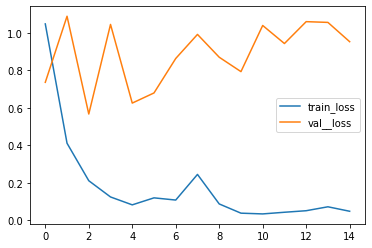

In [37]:
plt.plot(result_model.history["loss"], label = "train_loss")
plt.plot(result_model.history["val_loss"], label = "val__loss")
plt.legend()
plt.show()

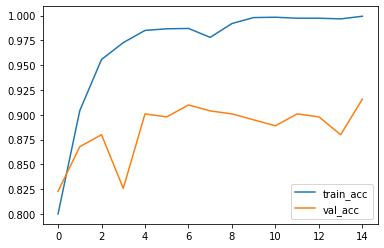

In [38]:
plt.plot(result_model.history["accuracy"], label = "train_acc")
plt.plot(result_model.history["val_accuracy"], label = "val_acc")
plt.legend()
plt.show()

In [39]:
_, acc = model_Inceptionv3.evaluate(test_generator)
print("Test accuracy : {} %".format(acc*100))

37/37 [==============================] - 2s 40ms/step - loss: 0.8755 - accuracy: 0.8983
Test accuracy : 89.83050584793091 %


0.8983050847457628
              precision    recall  f1-score   support

           0       0.92      0.92      0.92       376
           1       0.86      0.86      0.86       214

    accuracy                           0.90       590
   macro avg       0.89      0.89      0.89       590
weighted avg       0.90      0.90      0.90       590



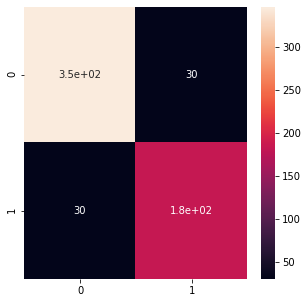

In [40]:
prediction = model_Inceptionv3.predict(test_generator)

pred = np.argmax(prediction, axis=1)
#pred = np.asarray(pred).astype('str')
original = np.asarray(test['mask']).astype('int')

from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
accuracy = accuracy_score(original, pred)
print(accuracy)

cm = confusion_matrix(original, pred)

report = classification_report(original, pred, labels = [0,1])
print(report)
plt.figure(figsize = (5,5))
sns.heatmap(cm, annot=True);

### Fine Tning

In [41]:
# Unfreeze the base model
inception_base.trainable = True

model_Inceptionv3.compile(loss = 'binary_crossentropy', optimizer=keras.optimizers.Adam(1e-5), metrics=["accuracy"])

# Train end-to-end. Be careful to stop before you overfit!
result_model = model_Inceptionv3.fit(train_generator, validation_data=valid_generator, epochs = 7)

Epoch 1/7
188/188 [==============================] - 32s 127ms/step - loss: 2.2188 - accuracy: 0.7762 - val_loss: 1.5033 - val_accuracy: 0.8468
Epoch 2/7
188/188 [==============================] - 22s 117ms/step - loss: 0.6286 - accuracy: 0.8901 - val_loss: 1.3770 - val_accuracy: 0.8559
Epoch 3/7
188/188 [==============================] - 22s 117ms/step - loss: 0.3759 - accuracy: 0.9350 - val_loss: 1.2278 - val_accuracy: 0.8589
Epoch 4/7
188/188 [==============================] - 22s 117ms/step - loss: 0.2475 - accuracy: 0.9606 - val_loss: 0.9544 - val_accuracy: 0.8769
Epoch 5/7
188/188 [==============================] - 22s 118ms/step - loss: 0.1220 - accuracy: 0.9743 - val_loss: 1.0465 - val_accuracy: 0.8619
Epoch 6/7
188/188 [==============================] - 22s 117ms/step - loss: 0.1256 - accuracy: 0.9735 - val_loss: 1.0356 - val_accuracy: 0.8649
Epoch 7/7
188/188 [==============================] - 22s 117ms/step - loss: 0.0971 - accuracy: 0.9778 - val_loss: 0.8803 - val_accuracy:

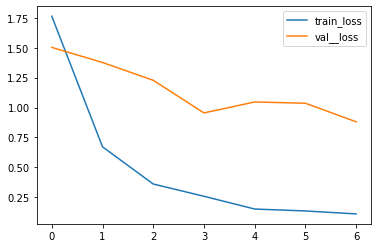

In [42]:
plt.plot(result_model.history["loss"], label = "train_loss")
plt.plot(result_model.history["val_loss"], label = "val__loss")
plt.legend()
plt.show()

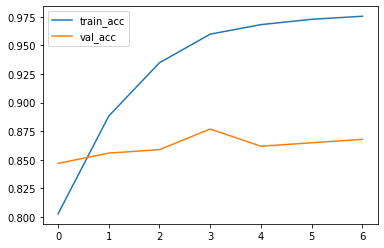

In [43]:
plt.plot(result_model.history["accuracy"], label = "train_acc")
plt.plot(result_model.history["val_accuracy"], label = "val_acc")
plt.legend()
plt.show()

In [44]:
_, acc = model_Inceptionv3.evaluate(test_generator)
print("Test accuracy : {} %".format(acc*100))

37/37 [==============================] - 2s 39ms/step - loss: 0.7460 - accuracy: 0.8932
Test accuracy : 89.32203650474548 %


0.8932203389830509
              precision    recall  f1-score   support

           0       0.90      0.93      0.92       376
           1       0.88      0.82      0.85       214

    accuracy                           0.89       590
   macro avg       0.89      0.88      0.88       590
weighted avg       0.89      0.89      0.89       590



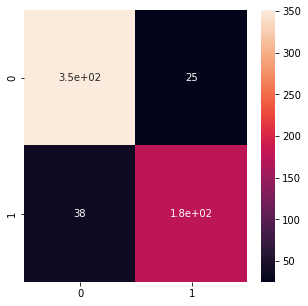

In [45]:
prediction = model_Inceptionv3.predict(test_generator)

pred = np.argmax(prediction, axis=1)
#pred = np.asarray(pred).astype('str')
original = np.asarray(test['mask']).astype('int')

from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
accuracy = accuracy_score(original, pred)
print(accuracy)

cm = confusion_matrix(original, pred)

report = classification_report(original, pred, labels = [0,1])
print(report)
plt.figure(figsize = (5,5))
sns.heatmap(cm, annot=True);